In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB


In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tabulate

UNNORMALIZE_FACTOR = 131  # MAX(HomeSpreadActual) - MIN(HomeSpreadActual)
UNNORMALIZE_FACTOR_PREDICT = 41

# REGRESSION
# Return X = testable features, Y = point spread
def spread_df_rgn(normalize=False, get_custom_date_range=False, substituted_spreads=None):
  data_df = pd.read_csv('combined_out.csv')

  real_cols = data_df.select_dtypes(include=['number']).columns

  if not get_custom_date_range:
    data_df = data_df.dropna(axis=0)

  if normalize:
    for col in real_cols:
      min_val = data_df[col].min()
      max_val = data_df[col].max()
      data_df[col] = (data_df[col] - min_val) / (max_val - min_val)

  if get_custom_date_range:
    data_df = data_df[(data_df['Date'] >= '2024-04-01') & (data_df['Date'] <= '2024-04-07')]
    data_df['HomeSpread'] = substituted_spreads
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadActual'] > data_df['HomeSpread']
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadCorrectDirection'].astype(int)
  
  data_df = data_df.drop('AwayTeam', axis=1)\
                   .drop('HomeTeam', axis=1)\
                   .drop('Date', axis=1)
  
  data_np = data_df.to_numpy()
  data_np = data_np[:, 5:]

  data_np = data_np.astype(float)

  return data_np[:, 1:-1], data_np[:, :1]

# CLASSIFICATION
# Return X = testable features, Y = correct point spread direction
def spread_df_cls(normalize=False, get_custom_date_range=False, substituted_spreads=None):
  data_df = pd.read_csv('combined_out.csv')

  real_cols = data_df.select_dtypes(include=['number']).columns

  if not get_custom_date_range:
    data_df = data_df.dropna(axis=0)

  if normalize:
    for col in real_cols:
      min_val = data_df[col].min()
      max_val = data_df[col].max()
      data_df[col] = (data_df[col] - min_val) / (max_val - min_val)

  if get_custom_date_range:
    data_df = data_df[(data_df['Date'] >= '2024-04-01') & (data_df['Date'] <= '2024-04-07')]
    data_df['HomeSpread'] = substituted_spreads
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadActual'] > data_df['HomeSpread']
    data_df['HomeSpreadCorrectDirection'] = data_df['HomeSpreadCorrectDirection'].astype(int)

  data_df = data_df.drop('AwayTeam', axis=1)\
                   .drop('HomeTeam', axis=1)\
                   .drop('Date', axis=1)
  
  data_np = data_df.to_numpy()
  data_np = data_np[:, 5:]

  data_np = data_np.astype(float)

  return data_np[:, 1:-1], data_np[:, -1:]

In [3]:
X, y = spread_df_cls()
# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

# Initializing the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Training the model
gnb.fit(X_train, y_train)

# Making predictions
y_pred = gnb.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.5252397778899546
Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.56      0.54      1971
         1.0       0.53      0.50      0.51      1991

    accuracy                           0.53      3962
   macro avg       0.53      0.53      0.52      3962
weighted avg       0.53      0.53      0.52      3962



/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


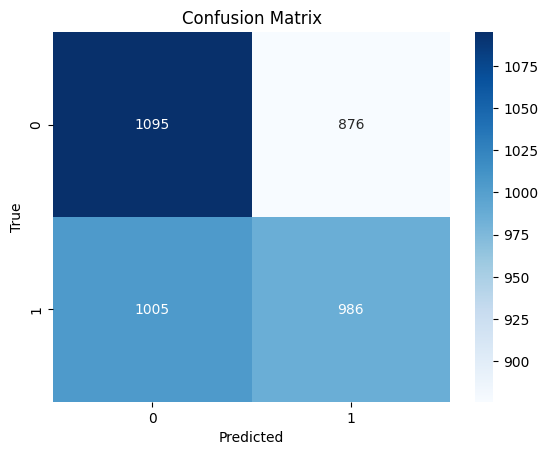

In [4]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

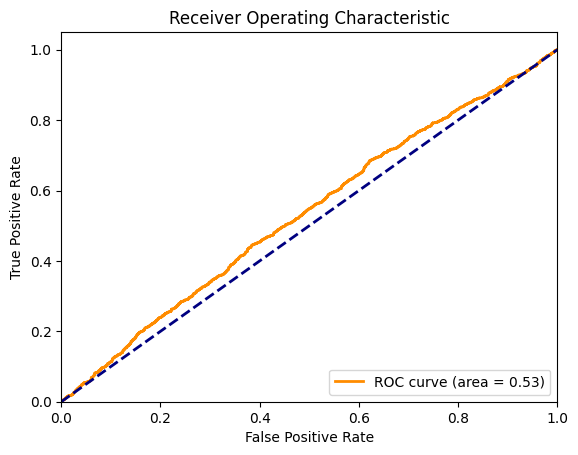

In [6]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score

X, y = spread_df_cls()

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# Creating a pipeline with feature selection and GaussianNB
pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_classif)),
    ('gnb', GaussianNB())
])

# Parameter grid to search over
param_grid = {
    'select__k': range(1, 21)  # Assuming the original data has 20 features, adjust accordingly
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Displaying the best parameters and the corresponding score
print("Best parameters found:")
print(grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Optionally, evaluate the best model on the test set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Best parameters found:
{'select__k': 3}
Best cross-validation score: 0.541
Test set accuracy: 0.541140837960626


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,